# Texas House and Texas Senate District Mappings

In [96]:
### LIST OF HELPER FUNCTIONS ###

## Libraries:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

import os
import datetime
from geopy.geocoders import GoogleV3
import wget
import zipfile

## Helper Functions: Importing Google API key
apiKey_googleMaps = os.environ['apiKey_googleMaps']


## Helper Function: Exporting data to CSV, tab-delimited, or Excel
def exportAndSaveDF(dataframe, fileName, exportDirectory, type="xlsx"):
    """Export a pandas.DataFrame to either `xlsx` or `tab` file format."""
    date_suffix=(datetime.datetime.now().strftime("%Y%m%d_%H%M_%S_%f"))  # Including microseconds to differentiate files
    
    if (type=="xlsx"):
        ## Export to Excel
        dataframe.to_excel(f"{exportDirectory}/{fileName}_{date_suffix}.xlsx")
    elif (type=="tab"):
        ## Export to tab-delimited file (Can be read with Excel)
        dataframe.to_csv(f"{exportDirectory}/{fileName}_{date_suffix}.tab", sep="\t")
    else:
        print("Select either `xlsx` or `tab` for the export file type.")

        
## Helper Function: Joins compound address components
def joinAddress(row):
    '''Joins compound address fields into single string and strip spaces.
    
    The function also strings leading and trailing spaced that causes issues with .tab
    '''
    if (isinstance(row[mask_address_cols[0]], float) | 
        isinstance(row[mask_address_cols[1]], float) | 
        isinstance(row[mask_address_cols[2]], float) | 
        isinstance(row[mask_address_cols[3]], float)):
        print(f"This is invalid: ")
        print(row)
    return(str(row[mask_address_cols[0]]).strip() + ", " + 
           row[mask_address_cols[1]].strip() + ", " + 
           row[mask_address_cols[2]].strip() + " " + 
           str(row[mask_address_cols[3]]).strip())


## Helper Function: Check file path and file type
def fileCheckAndImport(fileDirectory, fileName):
    """Check and import file, returned as a dataframe"""
    
    if re.search("\.xlsx$", fileName):
        filePath_excel = f"{fileDirectory}/{fileName}"
        return pd.read_excel(filePath_excel, engine="openpyxl")
    
    elif re.search("\.csv$", fileName):
        filePath_csv = f"{fileDirectory}/{fileName}"
        return pd.read_csv(filePath_csv)
    
    else:
        print(f"Something is wrong, either file does not exist or not xlsx/csv file.")
        
        
## Helper function: Extract latitude and longitude
def extract_lat_long(address):
    with GoogleV3(api_key=apiKey_googleMaps) as geolocator:
        try:
            location = geolocator.geocode(address)
            return (location.latitude, location.longitude)
        except:
            return ""

## Helper function: Extract standardized and formatted address
def extract_clean_address(address):
    with GoogleV3(api_key=apiKey_googleMaps) as geolocator:
        try:
            location = geolocator.geocode(address)
            return location.address
        except:
            return ""

## Helper function: Extract raw
def extract_raw(address):
    with GoogleV3(api_key=apiKey_googleMaps) as geolocator:
        try:
            location = geolocator.geocode(address)
            return location.raw
        except:
            return ""
        
        
## Helper Function: Download and Unzip files
def downloadAndUnzip(downloadUrl, downloadDirectory="./data"):
    """Download and unzip files."""
    filePath = wget.download(downloadUrl, downloadDirectory, bar=None)
    
    with zipfile.ZipFile(filePath, "r") as zip_ref:
        zip_ref.extractall(downloadDirectory)
        # print(zip_ref.infolist())
    

## Importing the Files

In [2]:
### User Input Fields ###

## File names - PLEASE INPUT
fileDirectory = "./data/"
fileName = "SFDataImport_AmeriCorpsTX_ServiceSites_2021-22.xlsx"


In [3]:
import pandas as pd
import warnings
import re

## Ignore warnings
warnings.filterwarnings("ignore")  # Comment out if WANT warnings

## Check filetype
df = fileCheckAndImport(fileDirectory, fileName)  # Check file type: need xlsx or csv

## Dataframe masks
mask_address_cols = ["Billing Address", "Billing City", "Billing State/Province", "Billing Zip/Postal Code"]
mask_no_missing_val = df[mask_address_cols].isna().sum(axis=1).apply(lambda x: True if x==0 else False)

In [4]:
## Create 'Full Address' column in DataFrame
## NOTES: 
## - Rows with missing values are skipped
  
## Create a new column `full_address`
df.loc[mask_no_missing_val, "full_address"] = df.loc[mask_no_missing_val, mask_address_cols].apply(joinAddress, axis=1)
display(df[(mask_address_cols + ["full_address"])])  # Display the new dataframe subset

,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,full_address
0,2407 S. Houston,Amarillo,TX,79103,"2407 S. Houston, Amarillo, TX 79103"
1,3901 SE 15th,Amarillo,TX,79104,"3901 SE 15th, Amarillo, TX 79104"
2,3800 S. Lipscomb,Amarillo,TX,79110,"3800 S. Lipscomb, Amarillo, TX 79110"
3,3209 S. Taylor,Amarillo,TX,79110,"3209 S. Taylor, Amarillo, TX 79110"
4,2215 S. Bivins,Amarillo,TX,79103,"2215 S. Bivins, Amarillo, TX 79103"
...,...,...,...,...,...
677,900 Ave Q,Sunray,TX,79086,"900 Ave Q, Sunray, TX 79086"
678,1701 23rd St,Canyon,TX,79015,"1701 23rd St, Canyon, TX 79015"
679,5800 Attebury Dr,Canyon,TX,79118,"5800 Attebury Dr, Canyon, TX 79118"
680,1401 23rd St,Canyon,TX,79015,"1401 23rd St, Canyon, TX 79015"


In [5]:
## Quick address pattern checking
## NOTES:
## - Google Maps cannot return PO Box
## - 1600B is a valid address, there is not a space between door number and `B` --> Regex will not catch this

## Variables
regex_pattern=r"^(\d+ *\w+)"  # One or more street number followed by an optional space, and a word with one or more characters.

## Counting bad addressses according to regex_pattern
df["full_address"].str.match(regex_pattern).value_counts()  # There are 4 bad address

## Show the problematic address
mask_good_address = df["full_address"].str.match(regex_pattern).astype(bool)
display(df.loc[~mask_good_address, (mask_address_cols+["full_address"])])


,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,full_address
222,Po Box 191405,Dallas,TX,75219-1405,"Po Box 191405, Dallas, TX 75219-1405"


In [6]:
## Add `googleMaps_lat_long` and `googleMaps_clean_address` columns
## Queries Google Maps API for geo data

# df.loc[mask_no_missing_val, "googleMaps_lat_long"] = df.loc[mask_no_missing_val, "full_address"].apply(extract_lat_long)
# df.loc[mask_no_missing_val, "googleMaps_clean_address"] = df.loc[mask_no_missing_val, "full_address"].apply(extract_clean_address)

## For Testing -- Only queries the first few records
# df.loc[mask_no_missing_val, "googleMaps_lat_long"] = df.loc[mask_no_missing_val, "full_address"].head().apply(extract_lat_long)
# df.loc[mask_no_missing_val, "googleMaps_clean_address"] = df.loc[mask_no_missing_val, "full_address"].head().apply(extract_clean_address)



In [7]:
## Testing (IGNORE)
## NOTES: 
## - Sometimes when Google API can't find the result, it returns just the city.
## - Google Maps data are crowdsourced and can be incorrect, such as San Jacinto Elementary School below
## - May want to look into USPS option

## Test Raw - Google Maps API provides raw data access as well
# print(extract_raw(df.loc[3, 'full_address']))
# print(extract_raw("200 Ave F, Hereford, TX 79045"))

## Issues Test
# print(extract_raw("3400 W. 4th, Amarillo, TX 79106"))  # Google Maps returns the city Amarillo, Google Maps address does not match USPS


In [8]:
## Exporting data

## Export to Excel file
exportAndSaveDF(df, fileName, "data", type="xlsx")

## Export to tab-delimited-file (can be opened by Excel)
exportAndSaveDF(df, fileName, "data", type="tab")

## Points in Polygon (Finding which district an address belongs to)

In [9]:
### Summary >>> [Source](https://redistricting.capitol.texas.gov/history)
##
## Texas Congressional Districts
## - Texas Senate Districts: 
##    - 2002-2010 - Plan01188S
##    - 2012-2020 - PlanS172
##    - 2022 (Primary and general elections) - SB 4 - PlanS2168
##
## - Texas House Districts: 
##    - 2002-2010 - Plan01369H
##    - 2012 - PlanH309
##    - 2014-2018 - PlanH358
##    - 2020 - PlanH414
##    - 2022 (Primary and general elections) - HB 1 - PlanH2316
## - Texas Board of Education Districts: 
##    - 2022 (Primary and general elections) - SB 7 - PlanE2106
##
## Texas Congressional Districts (US House Districts in Texas)
##    - 2002 - PLAN01151C
##    - 2004-2006 - PLAN01374C
##    - 2006-2010 - PLAN01440C
##    - 2012-2020 - PLANC235
##    - 2022 (Primary and general elections) - SB 6 - PlanC193

In [113]:
## read file
df = pd.read_excel("./data/SFDataImport_AmeriCorpsTX_ServiceSites_2021-22.xlsx_cleanFile_20220725_1506_44_883408.xlsx", engine="openpyxl", index_col=0)
# display(df)

## Change lat/long file type from str -> tuple
df.loc[mask_no_missing_val, "googleMaps_long_lat"] = df.loc[mask_no_missing_val, "googleMaps_lat_long"].apply(lambda row: tuple([float(i) for i in row.strip("()").split(", ")[::-1]]))
df.loc[mask_no_missing_val, "coords"] = df.loc[mask_no_missing_val, "googleMaps_long_lat"].apply(Point)  # Add `coords` column of shapely.Points objects

## Check
display(df.head())

,Site Name,Type,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,Grant,# Full Time Slots,# Three Quarter Time Slots,# Half Time Slots,# Reduced Half Time Slots,# Quarter-Time Slots,# Minimum Time Slots,# Abbreviated Time Slots,full_address,googleMaps_lat_long,googleMaps_clean_address,googleMaps_long_lat,coords
0,Glenwood Elementary School,Education-K thru 12,2407 S. Houston,Amarillo,TX,79103,21-22 Amarillo ISD ACTX,NaN,NaN,NaN,2.0,NaN,NaN,NaN,"2407 S. Houston, Amarillo, TX 79103","(35.1875439, -101.8237399)","2407 S Houston St, Amarillo, TX 79103, USA","(-101.8237399, 35.1875439)",POINT (-101.8237399 35.1875439)
1,Humphrey's Highland Elementary School,Education-K thru 12,3901 SE 15th,Amarillo,TX,79104,21-22 Amarillo ISD ACTX,NaN,NaN,1,5.0,NaN,NaN,NaN,"3901 SE 15th, Amarillo, TX 79104","(35.1967066, -101.7908832)","3901 SE 15th Ave, Amarillo, TX 79104, USA","(-101.7908832, 35.1967066)",POINT (-101.7908832 35.1967066)
2,Lamar Elementary School,Education-K thru 12,3800 S. Lipscomb,Amarillo,TX,79110,21-22 Amarillo ISD ACTX,NaN,NaN,NaN,2.0,NaN,NaN,NaN,"3800 S. Lipscomb, Amarillo, TX 79110","(35.1737463, -101.8545579)","3800 S Lipscomb St, Amarillo, TX 79110, USA","(-101.8545579, 35.1737463)",POINT (-101.8545579 35.1737463)
3,Landergin Elementary School,Education-K thru 12,3209 S. Taylor,Amarillo,TX,79110,21-22 Amarillo ISD ACTX,NaN,NaN,NaN,2.0,NaN,NaN,NaN,"3209 S. Taylor, Amarillo, TX 79110","(35.1788868, -101.8391701)","3209 S Taylor St, Amarillo, TX 79110, USA","(-101.8391701, 35.1788868)",POINT (-101.8391701 35.1788868)
4,Lawndale Elementary School,Education-K thru 12,2215 S. Bivins,Amarillo,TX,79103,21-22 Amarillo ISD ACTX,NaN,NaN,NaN,2.0,NaN,NaN,NaN,"2215 S. Bivins, Amarillo, TX 79103","(35.1875445, -101.8068325)","2215 S Bivins St, Amarillo, TX 79103, USA","(-101.8068325, 35.1875445)",POINT (-101.8068325 35.1875445)


In [114]:
## Download Shapefiles

## Shape file sources
txHouse_2022 = "https://data.capitol.texas.gov/dataset/71af633c-21bf-42cf-ad48-4fe95593a897/resource/a4d3230f-47f2-4253-85f3-51a6c3c9ad0a/download/planh2316.zip"
txSenate_2022 = "https://data.capitol.texas.gov/dataset/70836384-f10c-423d-a36e-748d7e000872/resource/8247dbc6-b942-4a29-813c-1ebc603a7236/download/plans2168.zip"
usHouse_2022 = "https://data.capitol.texas.gov/dataset/a5d7c6ad-8e3b-4a32-885f-0398585d683b/resource/2b38aac7-2887-47fd-8909-8f882e179b9a/download/planc193.zip"

downloadAndUnzip(txHouse_2022)
downloadAndUnzip(txSenate_2022)
downloadAndUnzip(usHouse_2022)


In [84]:
## District shape files
txHouse_shp = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANH2316/PLANH2316.shp").to_crs("WGS84").rename(columns={"District": "tx_house_district"})  # Converted to EPSG4326
txSenate_shp = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANS2168/PLANS2168.shp").to_crs("WGS84").rename(columns={"District": "tx_senate_district"})  # Converted to EPSG4326
usHouse_shp = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANC193/PLANC193.shp").to_crs("WGS84").rename(columns={"District": "us_house_district"})  # Converted to EPSG4326

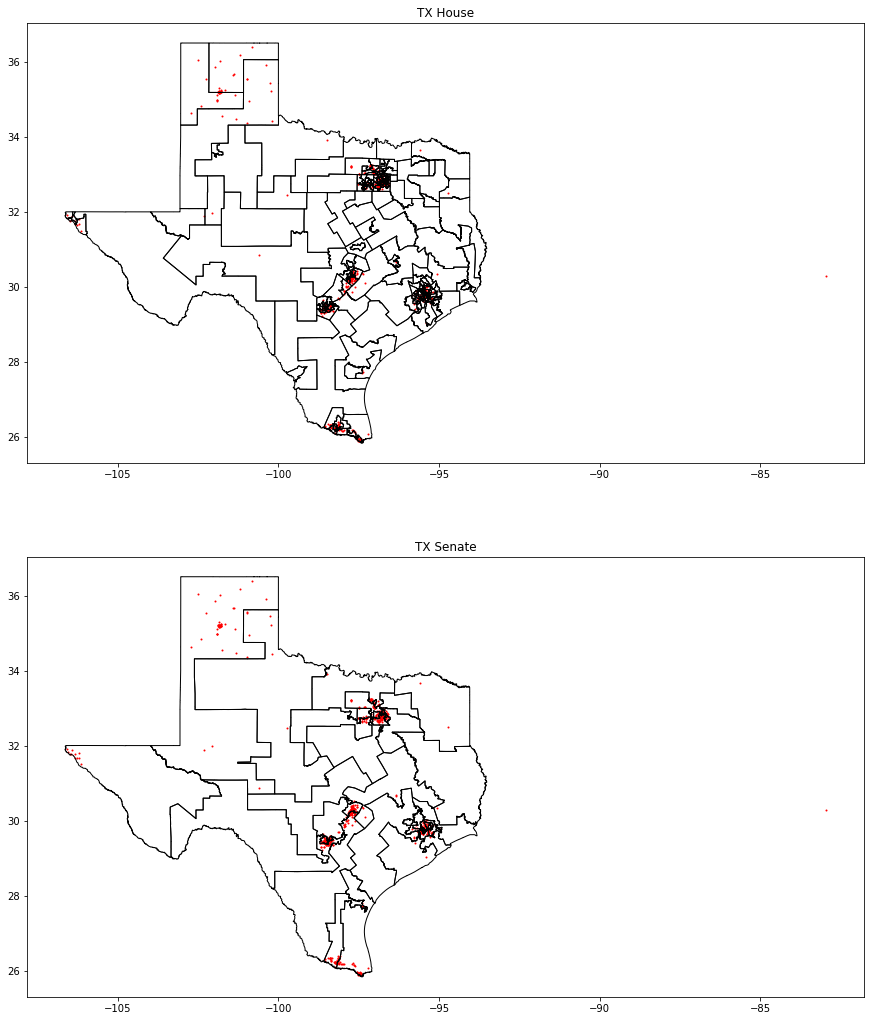

In [116]:
## Plot service sites on each kinds of district maps
serviceSites_2021_2022 = gpd.GeoDataFrame(df.loc[mask_no_missing_val, :], geometry="coords", crs="EPSG:4326")
txHouse_join = gpd.tools.sjoin(serviceSites_2021_2022, txHouse_shp, predicate="within", how="left")
txSenate_join = gpd.tools.sjoin(serviceSites_2021_2022, txSenate_shp, predicate="within", how="left")
usHouse_join = gpd.tools.sjoin(serviceSites_2021_2022, usHouse_shp, predicate="within", how="left")


## Base Plot arguments
fig, ax = plt.subplots(2, 1, figsize=(15, 18))  # Figure instantiation
base_plot_arg = {"linewidth": 1,
                 "edgecolor": "black"}

## Tx House Plot
base_txHouse = txHouse_shp.boundary.plot(**base_plot_arg, ax=ax[0])
txHouse_join.plot(ax=base_txHouse, linewidth=1, color="red", markersize=1)
base_txHouse.set_title("TX House")

## Tx Senate Plot
base_txSenate = txSenate_shp.boundary.plot(**base_plot_arg, ax=ax[1])
txSenate_join.plot(ax=base_txSenate, linewidth=1, color="red", markersize=1)
base_txSenate.set_title("TX Senate")

## Save TX House and TX Senate
fig.savefig("txHouseSenate_2022District_2021_2022_ServiceSite_Mapping.jpeg")
plt.show()


## US House Plot
# base_usHouse = usHouse_shp.boundary.plot(**base_plot_arg)
# usHouse_join.plot(ax=base_usHouse, linewidth=1, color="red", markersize=1)
# base_usHouse.set_title("US House")
# plt.show()

In [117]:
## Join TX-House and TX-Senate districts data with original table
df = df.join([txHouse_join.iloc[:, -1], txSenate_join.iloc[:, -1]], how="outer")
display(df.head())


,Site Name,Type,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,Grant,# Full Time Slots,# Three Quarter Time Slots,# Half Time Slots,...,# Quarter-Time Slots,# Minimum Time Slots,# Abbreviated Time Slots,full_address,googleMaps_lat_long,googleMaps_clean_address,googleMaps_long_lat,coords,tx_house_district,tx_senate_district
0,Glenwood Elementary School,Education-K thru 12,2407 S. Houston,Amarillo,TX,79103,21-22 Amarillo ISD ACTX,NaN,NaN,NaN,...,NaN,NaN,NaN,"2407 S. Houston, Amarillo, TX 79103","(35.1875439, -101.8237399)","2407 S Houston St, Amarillo, TX 79103, USA","(-101.8237399, 35.1875439)",POINT (-101.8237399 35.1875439),87.0,31.0
1,Humphrey's Highland Elementary School,Education-K thru 12,3901 SE 15th,Amarillo,TX,79104,21-22 Amarillo ISD ACTX,NaN,NaN,1,...,NaN,NaN,NaN,"3901 SE 15th, Amarillo, TX 79104","(35.1967066, -101.7908832)","3901 SE 15th Ave, Amarillo, TX 79104, USA","(-101.7908832, 35.1967066)",POINT (-101.7908832 35.1967066),87.0,31.0
2,Lamar Elementary School,Education-K thru 12,3800 S. Lipscomb,Amarillo,TX,79110,21-22 Amarillo ISD ACTX,NaN,NaN,NaN,...,NaN,NaN,NaN,"3800 S. Lipscomb, Amarillo, TX 79110","(35.1737463, -101.8545579)","3800 S Lipscomb St, Amarillo, TX 79110, USA","(-101.8545579, 35.1737463)",POINT (-101.8545579 35.1737463),86.0,31.0
3,Landergin Elementary School,Education-K thru 12,3209 S. Taylor,Amarillo,TX,79110,21-22 Amarillo ISD ACTX,NaN,NaN,NaN,...,NaN,NaN,NaN,"3209 S. Taylor, Amarillo, TX 79110","(35.1788868, -101.8391701)","3209 S Taylor St, Amarillo, TX 79110, USA","(-101.8391701, 35.1788868)",POINT (-101.8391701 35.1788868),86.0,31.0
4,Lawndale Elementary School,Education-K thru 12,2215 S. Bivins,Amarillo,TX,79103,21-22 Amarillo ISD ACTX,NaN,NaN,NaN,...,NaN,NaN,NaN,"2215 S. Bivins, Amarillo, TX 79103","(35.1875445, -101.8068325)","2215 S Bivins St, Amarillo, TX 79103, USA","(-101.8068325, 35.1875445)",POINT (-101.8068325 35.1875445),87.0,31.0


In [99]:
## Export file
exportAndSaveDF(df, "DistrictMapped_version_1", fileDirectory, type='xlsx')

## Investigate Incorrect Entries

In [39]:
mask_get_unnamed_col = df.columns[df.columns.str.match("unnamed", case=False)]
# display(txHouse_pointsInPolys.drop(mask_get_unnamed_col, axis=1))  # Dropping odd "unnamed column"

## Change dtypes
dtype_dict = {"index_right": int, "District": int}
# txHouse_pointsInPolys.astype(dtype_dict)


## Find districts of NA type
txHouse_pointsInPolys[txHouse_pointsInPolys.District.isna()]  # This is showing that Navasota High School's Google Maps' address is inaccurate

,Unnamed: 0,Site Name,Type,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,Grant,# Full Time Slots,# Three Quarter Time Slots,...,# Quarter-Time Slots,# Minimum Time Slots,# Abbreviated Time Slots,full_address,googleMaps_lat_long,googleMaps_clean_address,googleMaps_long_lat,coords,index_right,District
374,374,Navasota High School,Education-K thru 12,9238 Hwy 90,NAVASOTA,TX,77868-4776,21-22 College Advising Corps ACTX,1,NaN,...,NaN,NaN,NaN,"9238 Hwy 90, NAVASOTA, TX 77868-4776","(30.2817636, -82.9512785)","9238 US-90, Live Oak, FL 32060, USA","(-82.9512785, 30.2817636)",POINT (-82.95128 30.28176),NaN,NaN


In [125]:
## - Check districts after mask that have NAN
## NOTES: 
## - There are 10x values that have NaN as district information because address information was missing.
## - There is 1x entry with NaN as district information (e.g. Navasota High School) 
##   because the address provided does not match that on Google Maps.
##   - ??? What is Navasota High School's real address
##     - Answer: Both addresses are valid according to USPS and may be due to street renaming with city's expansion. 
##       However TAMU Geoservices is able to return the geocode for both address correctly.

mask_temp = df.tx_house_district.isna()
display(df[mask_temp])

,Site Name,Type,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,Grant,# Full Time Slots,# Three Quarter Time Slots,# Half Time Slots,...,# Quarter-Time Slots,# Minimum Time Slots,# Abbreviated Time Slots,full_address,googleMaps_lat_long,googleMaps_clean_address,googleMaps_long_lat,coords,tx_house_district,tx_senate_district
374,Navasota High School,Education-K thru 12,9238 Hwy 90,NAVASOTA,TX,77868-4776,21-22 College Advising Corps ACTX,1,NaN,NaN,...,NaN,NaN,NaN,"9238 Hwy 90, NAVASOTA, TX 77868-4776","(30.2817636, -82.9512785)","9238 US-90, Live Oak, FL 32060, USA","(-82.9512785, 30.2817636)",POINT (-82.9512785 30.2817636),NaN,NaN
456,Unknown KIPP (Dallas),Education-K thru 12,NaN,Dallas,TX,NaN,21-22 Relay ACTX,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,Unknown DISD (Dallas),Education-K thru 12,NaN,Dallas,TX,NaN,21-22 Relay ACTX,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,Unknown Uplift (Dallas),Education-K thru 12,NaN,Dallas,TX,NaN,21-22 Relay ACTX,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,Unknown Aldine ISD (Houston),Education-K thru 12,NaN,Houston,TX,NaN,21-22 Relay ACTX,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,Unknown Alief ISD (Houston),Education-K thru 12,NaN,Houston,TX,NaN,21-22 Relay ACTX,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,Unknown KIPP (Houston),Education-K thru 12,NaN,Houston,TX,NaN,21-22 Relay ACTX,30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,Unknown Spring Branch ISD (Houston),Education-K thru 12,NaN,Houston,TX,NaN,21-22 Relay ACTX,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,Unknown KIPP (San Antonio),Education-K thru 12,NaN,NaN,TX,NaN,21-22 Relay ACTX,7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,Unknown IDEA (San Antonio),Education-K thru 12,NaN,NaN,TX,NaN,21-22 Relay ACTX,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Manually fix Navasota High School's Geocode
# df.loc[374, "full_address"]

## Use